In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/sarveshwar22/BISAG_Weather_Forecasting/main/dataset/dataset_minTemp.csv \
    -O /tmp/minTemp.csv

--2021-07-03 14:41:06--  https://raw.githubusercontent.com/sarveshwar22/BISAG_Weather_Forecasting/main/dataset/dataset_minTemp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/minTemp.csv’

/tmp/minTemp.csv    100%[===================>]  66.33K  --.-KB/s    in 0.001s  

2021-07-03 14:41:06 (46.8 MB/s) - ‘/tmp/minTemp.csv’ saved [67921/67921]



In [ ]:
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [ ]:
import csv
time_step=[]
temps=[]

Text(0.5, 1.0, 'Minimum temperature')

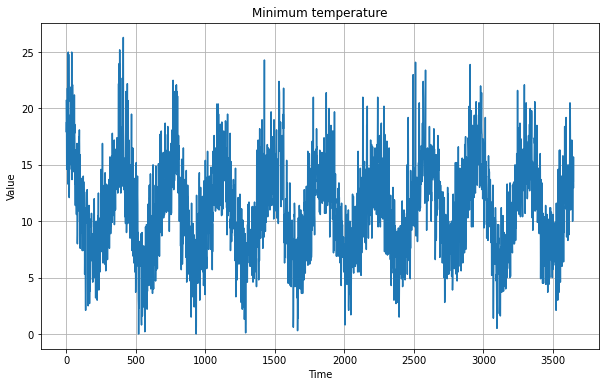

In [ ]:
with open('/tmp/minTemp.csv') as csvfile:
  reader=csv.reader(csvfile,delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step=step+1
series=np.array(temps)
time=np.array(time_step)
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.title("Minimum temperature")

In [ ]:
#70-20-10
split_time=2555
time_train=time[:split_time]
x_train=series[:split_time]

In [ ]:
split_time_test=3285
time_valid=time[split_time:split_time_test]
x_valid=series[split_time:split_time_test]
time_test=time[split_time_test:]
x_test=series[split_time_test:]


In [ ]:
window_size=30
batch_size=32
shuffle_buffer_size=1000

In [ ]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
  series=tf.expand_dims(series,axis=-1)
  ds= tf.data.Dataset.from_tensor_slices(series)
  ds= ds.window(window_size+1,shift=1,drop_remainder=True)
  ds= ds.flat_map(lambda w:w.batch(window_size+1))
  ds= ds.shuffle(shuffle_buffer)
  ds=ds.map(lambda w:(w[:-1],w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=64
batch_size=256
train_set=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)
valid_set=windowed_dataset(x_valid,window_size,batch_size,shuffle_buffer_size)

In [ ]:
model=tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1,padding="causal",
                             activation="relu",input_shape=[None,1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400)
])

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*(10**(epoch/20)))
optimizer=tf.keras.optimizers.SGD(lr=1e-8,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history=model.fit(train_set,validation_data=(valid_set),epochs=100,callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 8s 466ms/step - loss: 9.7359 - mae: 10.2248 - val_loss: 10.1610 - val_mae: 10.6505
Epoch 2/100
10/10 [==============================] - 4s 343ms/step - loss: 9.3086 - mae: 9.7975 - val_loss: 9.5638 - val_mae: 10.0513
Epoch 3/100
10/10 [==============================] - 4s 338ms/step - loss: 8.6557 - mae: 9.1431 - val_loss: 8.8015 - val_mae: 9.2885
Epoch 4/100
10/10 [==============================] - 4s 344ms/step - loss: 7.8623 - mae: 8.3488 - val_loss: 7.9153 - val_mae: 8.4006
Epoch 5/100
10/10 [==============================] - 4s 347ms/step - loss: 6.9727 - mae: 7.4582 - val_loss: 6.9099 - val_mae: 7.3965
Epoch 6/100
10/10 [==============================] - 4s 340ms/step - loss: 6.0086 - mae: 6.4928 - val_loss: 5.8473 - val_mae: 6.3307
Epoch 7/100
10/10 [==============================] - 4s 338ms/step - loss: 5.0761 - mae: 5.5564 - val_loss: 4.8949 - val_mae: 5.3758
Epoch 8/100
10/10 [==============================] - 4s 341ms/ste

(1e-08, 0.0001, 0.0, 60.0)

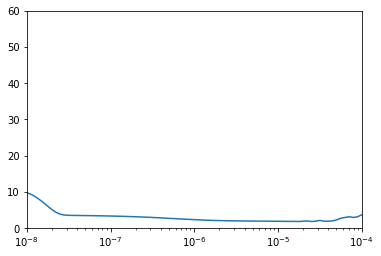

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
validation_set=windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,validation_data=(valid_set),epochs=150)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/150
25/25 [==============================] - 7s 172ms/step - loss: 5.4750 - mae: 5.9543 - val_loss: 2.6122 - val_mae: 3.0774
Epoch 2/150
25/25 [==============================] - 3s 134ms/step - loss: 2.6042 - mae: 3.0696 - val_loss: 2.3873 - val_mae: 2.8533
Epoch 3/150
25/25 [==============================] - 3s 131ms/step - loss: 2.1819 - mae: 2.6420 - val_loss: 2.0163 - val_mae: 2.4718
Epoch 4/150
25/25 [==============================] - 3s 132ms/step - loss: 2.0544 - mae: 2.5119 - val_loss: 2.0827 - val_mae: 2.5462
Epoch 5/150
25/25 [==============================] - 3s 132ms/step - loss: 1.9135 - mae: 2.3683 - val_loss: 2.0114 - val_mae: 2.4724
Epoch 6/150
25/25 [==============================] - 3s 131ms/step - loss: 1.8057 - mae: 2.2574 - val_loss: 1.6662 - val_mae: 2.1165
Epoch 7/150
25/25 [==============================] - 3s 133ms/step - loss: 1.8001 - mae: 2.2515 - val_loss: 1.6141 - val_mae: 2.0604
Epoch 8/150
25/25 [==============================] - 3s 133ms/step - 

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
print(rnn_forecast)

[15.753502 14.395579 13.921869 ... 13.520924 13.719681 15.164224]


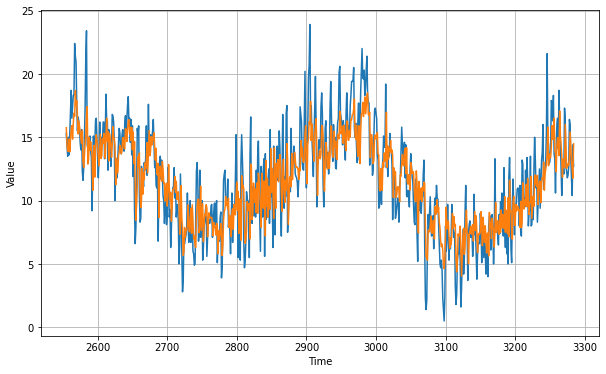

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast[:730])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

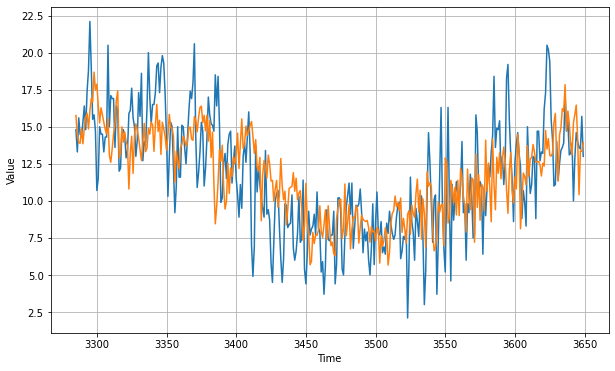

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast[:365])

In [ ]:
mae=tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast[:365]).numpy()
mae

2.2867205

In [ ]:
print(rnn_forecast)

[15.753502 14.395579 13.921869 ... 13.520924 13.719681 15.164224]


In [ ]:
accuracy=100-mae

In [ ]:
accuracy

97.71327948570251